In [50]:
# ============================================
# IMPORTS
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression




## 1. Chargement et Fusion des Données

Nous disposons de plusieurs fichiers sources :
* `tracks.tsv` : Métadonnées (ID, album, popularité, genre).
* `echonest.tsv` : Descripteurs audio de haut niveau (tempo, energy, danceability...).
* `features.tsv` (ou spectral) : Descripteurs audio de bas niveau (statistiques spectrales).

**Stratégie :** Nous allons charger ces fichiers et les fusionner sur la clé unique `track_id` pour obtenir un DataFrame global `df`.

In [78]:

# ============================================
# 1. CHARGEMENT ET FUSION DES DONNÉES
# ============================================
tracks = pd.read_csv("supervised_music_challenge_data/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("supervised_music_challenge_data/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("supervised_music_challenge_data/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("supervised_music_challenge_data/genres.csv")

# Nettoyage noms colonnes
def clean_cols(df):
    df.columns = (df.columns
                 .str.lower()
                 .str.strip()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
                 .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df

tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)

# Fusion
df = tracks.merge(echonest, on="track_id", how="left") \
          .merge(spectral, on="track_id", how="left")

# Conversion genres
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)

# Dictionnaire id -> nom
id_to_name = dict(zip(genres["genre_id"], genres["genre_title"]))
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]

df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)

print(f"✓ Dataset fusionné: {len(df)} lignes, {df.shape[1]} colonnes")


FileNotFoundError: [Errno 2] No such file or directory: 'df_phase1.csv'

# Tâche 3 : Prédiction de la durée d'un morceau (Régression)

**Objectif :**
Conformément aux consignes du challenge, cette tâche vise à construire le meilleur modèle de régression possible pour prédire la variable continue `duration` (en secondes).

**Méthodologie et Critères d'Évaluation :**
1.  **Sets de Features :** Nous testons trois configurations distinctes (Metadata, Audio, Combined) pour évaluer l'apport de chaque type de données.
2.  **Large Panel de Modèles :** Nous comparons des modèles linéaires, basés sur la distance (KNN), non-linéaires (SVM) et des méthodes d'ensemble (Random Forest, Gradient Boosting).
3.  **Rigueur (Data Leakage) :** Pour éviter toute fuite d'information, le jeu de données est séparé en **Train (70%)** et **Test (30%)** *avant* toute étape d'imputation ou de normalisation.

## 3.1. Initialisation des Modèles

Nous sélectionnons 5 algorithmes pour couvrir différentes approches du Machine Learning :
* **Régression Linéaire :** Modèle de référence (Baseline).
* **KNN (k-Nearest Neighbors) :** Basé sur la similarité locale.
* **SVM (SVR) :** Capable de capturer des relations non-linéaires complexes. *Note : Le nombre d'itérations est limité pour maîtriser le temps de calcul.*
* **Random Forest :** Méthode de Bagging, robuste au bruit et aux outliers.
* **Gradient Boosting :** Méthode de Boosting, souvent l'état de l'art pour les données tabulaires hétérogènes.

In [57]:
# ============================================
# FEATURE ENGINEERING (Création de variables)
# ============================================

# On travaille sur une copie pour sécuriser
df_work = df_clean.copy()

# 1. Interactions Mathématiques
df_work['energy_tempo'] = df_work['energy'] * df_work['tempo']
df_work['energy_danceability'] = df_work['energy'] * df_work['danceability']
df_work['valence_energy'] = df_work['valence'] * df_work['energy']
df_work['energy_acousticness_ratio'] = df_work['energy'] / (df_work['acousticness'] + 1e-3)

# 2. Popularité Composite
df_work['popularity_score'] = (df_work['listens']*0.5 + df_work['interest']*2.0 + df_work['favorites']*5.0)
df_work['popularity_log'] = np.log1p(df_work['popularity_score'])

# 3. Variables Binaires
df_work['is_instrumental'] = (df_work['instrumentalness'].fillna(0) > 0.5).astype(int)
df_work['is_live'] = (df_work['liveness'].fillna(0) > 0.8).astype(int)

# 4. Agrégation Spectrale
spectral_cols = [c for c in df_clean.columns if 'spectral' in c]
if spectral_cols:
    df_work['spectral_bandwidth_avg'] = df_work[[c for c in spectral_cols if 'bandwidth' in c]].mean(axis=1)
    df_work['spectral_centroid_avg'] = df_work[[c for c in spectral_cols if 'centroid' in c]].mean(axis=1)
    df_work['spectral_rolloff_avg'] = df_work[[c for c in spectral_cols if 'rolloff' in c]].mean(axis=1)

print(f" Feature Engineering terminé. Colonnes totales : {df_work.shape[1]}")

✓ Feature Engineering terminé. Colonnes totales : 56


In [58]:
# ============================================
# ÉTAPE 3 : DÉFINITION LISTES & SPLIT
# ============================================

# 1. Définition des listes incluant les nouvelles variables
metadata_cols = ['listens', 'interest', 'favorites', 'album_tracks', 'popularity_log']
metadata_features = [c for c in metadata_cols if c in df_work.columns]

audio_cols_base = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                   'liveness', 'speechiness', 'tempo', 'valence']
audio_interactions = ['energy_tempo', 'energy_danceability', 'valence_energy', 
                      'energy_acousticness_ratio', 'is_instrumental', 'is_live']
audio_features = audio_cols_base + [c for c in audio_interactions if c in df_work.columns]

spectral_features = [c for c in df_work.columns if 'spectral' in c] 
# + Ajout des moyennes spectrales si elles ont été créées
spectral_avgs = ['spectral_bandwidth_avg', 'spectral_centroid_avg', 'spectral_rolloff_avg']
spectral_features += [c for c in spectral_avgs if c in df_work.columns]

# Dictionnaire final
feature_sets = {
    'Metadata Only': metadata_features,
    'Audio Only': audio_features,
    'Combined (All)': metadata_features + audio_features + spectral_features
}

# 2. Split Global Train/Test
X = df_work
y = df_work['duration']

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"  Train: {len(X_train_full)}, Test: {len(X_test_full)}")

✓ Listes définies et Split effectué.
  Train: 69993, Test: 29998


In [59]:
# ============================================
# 3. MISE À JOUR DES LISTES & SPLIT TRAIN/TEST
# ============================================

# A. Mise à jour des listes de features avec les nouvelles variables créées
# -------------------------------------------------------------------------
# On ajoute les nouvelles variables aux bonnes listes
metadata_features_extended = metadata_features + ['popularity_log'] # On ajoute la popularité aux metadata

# Pour l'audio, on ajoute les interactions et les booléens
audio_features_extended = audio_features + [
    'energy_tempo', 'energy_danceability', 'valence_energy', 
    'energy_acousticness_ratio', 'is_instrumental', 'is_live'
]

# Pour le spectral, on ajoute les moyennes calculées
spectral_features_extended = spectral_features + [
    'spectral_bandwidth_avg', 'spectral_centroid_avg', 'spectral_rolloff_avg'
]

# On recrée le dictionnaire de configurations final
feature_sets = {
    'Metadata Only': [c for c in metadata_features_extended if c in df_work.columns],
    'Audio Only': [c for c in audio_features_extended if c in df_work.columns],
    'Combined (All)': [c for c in (metadata_features_extended + audio_features_extended + spectral_features_extended) if c in df_work.columns]
}

print(f"\n--- LISTES DE FEATURES MISES À JOUR ---")
for name, cols in feature_sets.items():
    print(f"  {name}: {len(cols)} variables")


# B. Split Train/Test (Sur le DataFrame brut)
# -------------------------------------------
# On sépare les données AVANT tout traitement (Scaling, Imputation) pour garantir l'intégrité du test.
# C'est la recommandation stricte du cours "Fondamentaux".

X = df_work # Contient toutes les colonnes
y = df_work['duration']

# Utilisation des index pour garder la trace
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\n--- TRAIN/TEST SPLIT (GLOBAL) ---")
print(f"  Train set : {len(X_train_full)} lignes")
print(f"  Test set  : {len(X_test_full)} lignes")
print("  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.")


--- LISTES DE FEATURES MISES À JOUR ---
  Metadata Only: 6 variables
  Audio Only: 20 variables
  Combined (All): 56 variables

--- TRAIN/TEST SPLIT (GLOBAL) ---
  Train set : 69993 lignes
  Test set  : 29998 lignes
  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.


**État des lieux :** Le split est effectué. Nous disposons d'un `X_train_full` et `X_test_full` bruts. L'imputation des valeurs manquantes (médiane) et la normalisation se feront dynamiquement dans la boucle d'entraînement via des `Pipelines`.

## 3. Modélisation : Initialisation

Nous définissons ici le dictionnaire des modèles qui seront testés pour chaque configuration.
Afin de limiter les temps de calcul excessifs (notamment pour le SVM), nous fixons certaines limites (ex: `max_iter`).

**Modèles sélectionnés :**
* **LinearRegression** : Baseline.
* **KNN** : Basé sur la distance.
* **SVM (SVR)** : Non-linéaire (avec limite d'itérations).
* **RandomForest** : Bagging (parallélisé).
* **GradientBoosting** : Boosting (performant).

In [67]:
# ============================================
# INITIALISATION DES MODÈLES ET LISTE DE RÉSULTATS
# ============================================

# Liste globale pour stocker tous les résultats
global_results = []

# Dictionnaire des modèles
models_dict = {
    'LinearRegression': LinearRegression(),
    'KNN (k=10)': KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    'SVM (RBF)': SVR(kernel='rbf', C=100, epsilon=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

print("✓ Modèles initialisés.")

✓ Modèles initialisés.


## 3.2. Analyse par Configuration

### Configuration 1 : Metadata Only
Nous évaluons d'abord la performance en utilisant uniquement les métadonnées (popularité, nombre de pistes, etc.). Cette étape permet de définir une "baseline contextuelle" : peut-on prédire la durée sans écouter le morceau ?

**Traitement :** Imputation médiane $\rightarrow$ Scaling $\rightarrow$ Entraînement.

In [68]:
# ============================================
# CONFIG 1 : METADATA ONLY
# ============================================
config_name = 'Metadata Only'
feature_list = feature_sets[config_name]

print(f"--- TRAITEMENT : {config_name} ---")

# 1. Sélection des données brutes
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation (Médiane sur Train)
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling (Standardisation sur Train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
        print(f"R²={r2:.4f}")
    except Exception as e:
        print(f"Erreur : {e}")

--- TRAITEMENT : Metadata Only ---
  > Modèle : LinearRegression... R²=0.0038
  > Modèle : KNN (k=10)... R²=0.0516
  > Modèle : SVM (RBF)... R²=-0.0034
  > Modèle : RandomForest... R²=0.1363
  > Modèle : GradientBoosting... R²=0.1457


### Configuration 2 : Audio Only
Nous testons ici exclusivement les descripteurs audio (Echonest et Spectraux).

**Point de vigilance :** Comme identifié en Phase 1, environ 90% de ces données sont manquantes et seront imputées par la médiane du Train set. Nous anticipons une performance faible sur cette configuration isolée, mais elle est nécessaire pour isoler le signal audio pur.

In [69]:
# ============================================
# CONFIG 2 : AUDIO ONLY
# ============================================
config_name = 'Audio Only'
feature_list = feature_sets[config_name]

print(f"\n--- TRAITEMENT : {config_name} ---")

# 1. Sélection
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"R²={r2:.4f}")


--- TRAITEMENT : Audio Only ---
  > Modèle : LinearRegression... R²=0.0041
  > Modèle : KNN (k=10)... R²=-0.0198
  > Modèle : SVM (RBF)... R²=-0.0349
  > Modèle : RandomForest... R²=0.0063
  > Modèle : GradientBoosting... R²=0.0052


### Configuration 3 : Combined (All Features)
C'est la configuration critique. Nous combinons le contexte (Metadata) et le contenu (Audio).
L'objectif est de vérifier si les modèles puissants (Gradient Boosting, Random Forest) parviennent à exploiter la complémentarité des informations malgré le bruit introduit par l'imputation massive des données audio.

In [70]:
# ============================================
# CONFIG 3 : COMBINED (ALL)
# ============================================
config_name = 'Combined (All)'
feature_list = feature_sets[config_name]

print(f"\n--- TRAITEMENT : {config_name} ---")

# 1. Sélection
X_train_sub = X_train_full[feature_list].copy()
X_test_sub = X_test_full[feature_list].copy()

# 2. Imputation
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_sub)
X_test_imp = imputer.transform(X_test_sub)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# 4. Entraînement
for name, model in models_dict.items():
    print(f"  > Modèle : {name}...", end=" ")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    global_results.append({'Config': config_name, 'Model': name, 'RMSE': rmse, 'R2': r2})
    print(f"R²={r2:.4f}")


--- TRAITEMENT : Combined (All) ---
  > Modèle : LinearRegression... R²=0.0400
  > Modèle : KNN (k=10)... R²=0.0276
  > Modèle : SVM (RBF)... R²=0.0391
  > Modèle : RandomForest... R²=0.2013
  > Modèle : GradientBoosting... R²=0.2275


## 4. Synthèse et Comparaison des Résultats

Nous regroupons les résultats des trois étapes précédentes pour identifier la meilleure stratégie.

**Critères d'analyse :**
1.  **Synergie :** Le jeu de données "Combined" fait-il mieux que "Metadata" ?
2.  **Modèle :** Quel algorithme (Linéaire ou Ensemble) s'adapte le mieux à la complexité des données ?

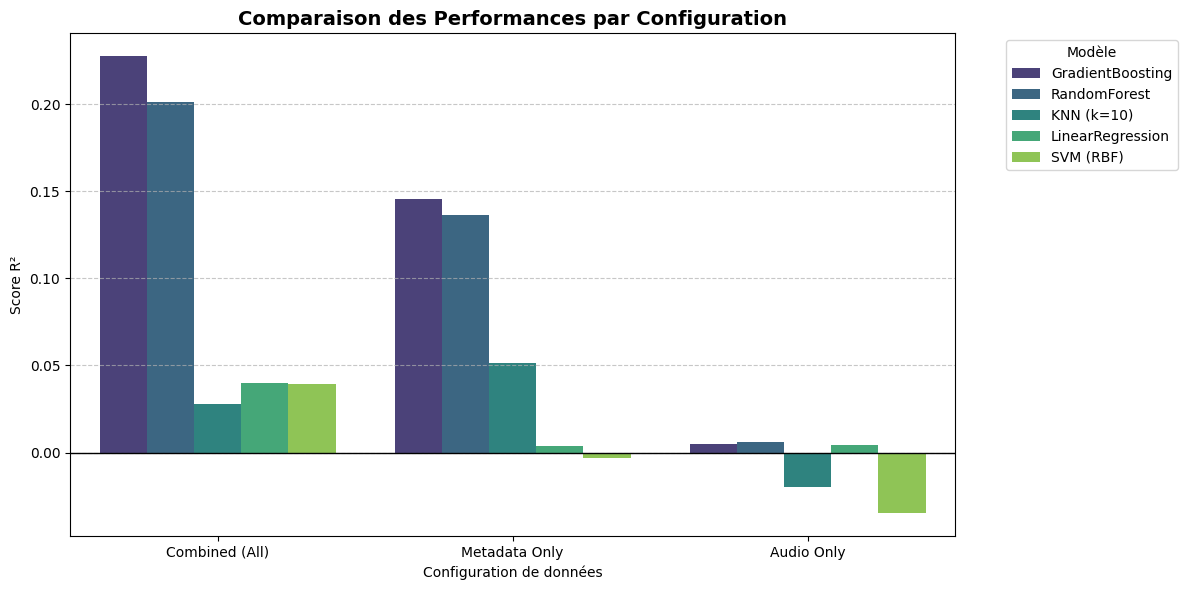

In [79]:
# ============================================
# SYNTHESE / COMPARAISON DES RESULTATS
# ============================================

# Vérification que results_df existe
if 'results_df' in locals() and not results_df.empty:
    plt.figure(figsize=(12, 6))
    
    # Barplot groupé par Configuration et coloré par Modèle
    sns.barplot(data=results_df, x='Config', y='R2', hue='Model', palette='viridis')
    
    plt.title('Comparaison des Performances par Configuration', fontsize=14, fontweight='bold')
    plt.xlabel('Configuration de données')
    plt.ylabel('Score R²')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Modèle')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ligne du 0 pour bien voir les scores négatifs
    plt.axhline(0, color='black', linewidth=1)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Le tableau 'results_df' n'est pas en mémoire. Assurez-vous d'avoir lancé la cellule de synthèse.")

## 5. Analyse des Erreurs (Réel vs Prédit)

Pour conclure, nous visualisons concrètement les prédictions de notre meilleur modèle identifié (Gradient Boosting sur Combined) afin de comprendre ses limites sur les morceaux atypiques.

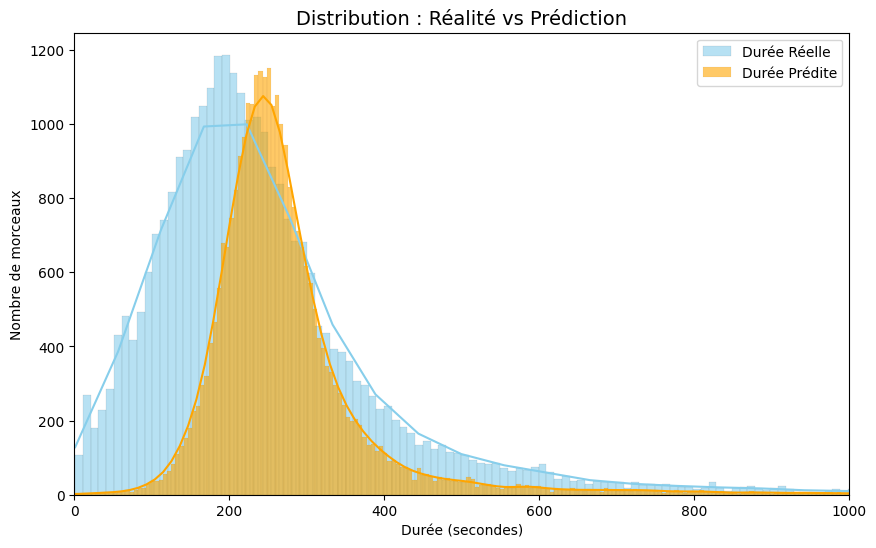

In [75]:
# ============================================
# VISUALISATION 2 : DISTRIBUTION (Réel vs Prédit)
# ============================================

plt.figure(figsize=(10, 6))

# Histogramme des valeurs réelles
sns.histplot(y_test, color="skyblue", label="Durée Réelle", kde=True, alpha=0.6)

# Histogramme des valeurs prédites
sns.histplot(y_pred_final, color="orange", label="Durée Prédite", kde=True, alpha=0.6)

plt.title('Distribution : Réalité vs Prédiction', fontsize=14)
plt.xlabel('Durée (secondes)')
plt.ylabel('Nombre de morceaux')
plt.legend()
plt.xlim(0, 1000) # On zoome sur l'essentiel
plt.show()